In [43]:
%matplotlib inline


Huấn luyện một máy phân loại
=====================

Dịch từ bài tiếng Anh: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Ở các bài trước, ta đã học về Tensor, tính đạo hàm tự động autograd, cách định nghĩa một mạng Neural, tính hàm mất mát và cập nhật trọng số với Pytorch. Trong bài này, ta sẽ kết hợp các kiến thức trên để huấn luyện một máy phân loại (classifier) trên ảnh.

Để huấn luyện máy phân loại thì điều quan trọng là phải chuẩn bị dữ liệu mẫu. Trong phần sau, ta sẽ mô tả khái quát việc chuẩn bị dữ liệu mẫu với Pytorch.

Chuẩn bị dữ liệu
----------------

Nói chung, khi làm việc với dữ liệu ảnh, văn bản, âm thanh hay video, bạn có thể dùng các công cụ python chuẩn để nạp dữ liệu vào mảng numpy, từ đó có thể chuyển mảng numpy thành ``torch.*Tensor``.

-  Với dữ liệu ảnh, các packages như Pillow, OpenCV sẽ hữu ích
-  Với dữ liệu âm thanh, các package như scipy và librosa sẽ hữu ích
-  Với dữ liệu văn bản, có thể dùng trực tiếp Python/Cython hoặc dùng các package như NLTK/SpaCy

Riêng với dữ liệu ảnh, pytorch có package ``torchvision`` với nhiều công cụ giúp nạp dữ liệu với các bộ dữ liệu thông dụng như Imagenet, CIFAR10, MNIST,..., và các bộ chuyển hoá dữ liệu (transformers) cho ảnh, video,...
qua các package con ``torchvision.datasets`` và ``torch.utils.data.DataLoader``.

Các công cụ này rất tiện dụng, giúp ta tránh phải viết mã dài dòng cho công việc chuẩn bị dữ liệu.

Trong bài này ta sẽ dùng bộ dữ liệu mẫu CIFAR10 với các phân loại ảnh như: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. Các ảnh trong bộ dữ liệu CIFAR-10 có kích thước 3x32x32, nghĩa là ảnh màu 3 channel với kích thước 32x32.

![cifar10](files/ch4_cifar10.png)

Huấn luyện máy phân loại ảnh
----------------------------

Ta sẽ thực hiện việc huấn luyện qua các bước sau:

1. Nạp và chuẩn hoá dữ liệu mẫu từ bộ dữ liệu CIFAR10 (chia ra làm tập huấn luyện và tập kiểm tra) với sự hỗ trợ của package ``torchvision``
2. Định nghĩa một mạng Neural Convolutional (CNN).
3. Định nghĩa hàm mất mát.
4. Huấn luyện mạng trên tập dữ liệu huấn luyện.
5. Kiểm tra độ chính xác trên tập dữ liệu kiểm tra.



Nạp và chuẩn hoá CIFAR10
----------------------------

Với package ``torchvision``, ta có thể nạp bộ dữ liệu CIFAR10 rất dễ dàng như sau:



In [44]:
import torch
import torchvision
import torchvision.transforms as transforms

Các bộ dữ liệu torchvision là ảnh dạng PILImage với trị số trong khoảng [0, 1]. Ta sẽ chuẩn hoá dữ liệu thành các Tensor với trị số trong khoảng [-1, 1]. (Lưu ý: bạn sẽ phải chờ một chút cho đoạn mã sau đây tải dữ liệu về từ Internet).

In [45]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('Máy Bay', 'Ôtô', 'Chim', 'Mèo',
           'Hươu', 'Chó', 'Ếch', 'Ngựa', 'Thuyền', 'Xe Tải')

Files already downloaded and verified
Files already downloaded and verified


Giờ ta hãy thử hiển thị một vài tấm ảnh trong bộ dữ liệu huấn luyện:

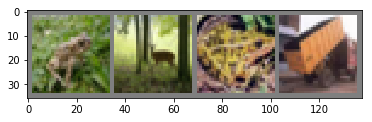

  Ếch   /    Hươu   /     Ếch   /   Xe Tải


In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Thủ tục này giúp hiển thị ảnh
def imshow(img):
    img = img / 2 + 0.5     # Ánh xạ giá trị lại khoảng [0, 1].
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Lấy vài tấm ảnh huấn luyện ngẫu nhiên
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Hiển thị ảnh
imshow(torchvision.utils.make_grid(images))
# In nhãn
print('   /   '.join('%5s' % classes[labels[j]] for j in range(4)))


## Định nghĩa mạng Neural Convolutional (CNN)

Ta sao chép lại mạng Neural định nghĩa trong bài học trước và chỉ cần sửa lại để nhận ảnh đầu vào có 3 channel thay vì 1 channel.

In [47]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Định nghĩa hàm mất mát và bộ tối ưu hoá

Ta hãy dùng hàm mất mát Cross-Entropy (thích hợp cho các bài toán phân loại), và bộ tối ưu hoá là SGD với momentum.

In [48]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Huấn luyện mạng

Bước này, ta chỉ cần lặp qua dữ liệu huấn luyện, đưa dữ liệu vào mạng và dùng bộ tối ưu hoá:

In [49]:
for epoch in range(2):  # Lặp qua bộ dữ liệu huấn luyện nhiều lần

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Lấy dữ liệu
        inputs, labels = data

        # Xoá giá trị đạo hàm
        optimizer.zero_grad()

        # Tính giá trị tiên đoán, đạo hàm, và dùng bộ tối ưu hoá để cập nhật trọng số.
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # In ra số liệu trong quá trình huấn luyện
        running_loss += loss.item()
        if i % 2000 == 1999:    # In mỗi 2000 mini-batches.
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Huấn luyện xong')

[1,  2000] loss: 2.223
[1,  4000] loss: 1.858
[1,  6000] loss: 1.703
[1,  8000] loss: 1.603
[1, 10000] loss: 1.537
[1, 12000] loss: 1.482
[2,  2000] loss: 1.385
[2,  4000] loss: 1.352
[2,  6000] loss: 1.333
[2,  8000] loss: 1.294
[2, 10000] loss: 1.280
[2, 12000] loss: 1.269
Huấn luyện xong


## Kiểm tra độ chính xác của mạng

Ta đã huấn luyện mạng với 2 lần lặp qua bộ dữ liệu huấn luyện. Bây giờ ta cần kiểm tra xem mạng đã thực sự học được việc phân loại ảnh hay chưa.

Để kiểm tra, ta lặp qua tập dữ liệu kiểm tra, dùng mạng để phân loại và ghi nhớ các ảnh được phân loại đúng.

Trước tiên, ta hãy hiển thị thử một ảnh từ tập dữ liệu kiểm tra:

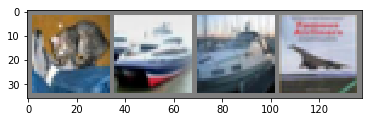

Nhãn đúng:    Mèo   /   Thuyền   /   Thuyền   /   Máy Bay


In [64]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# Hiển thị ảnh
imshow(torchvision.utils.make_grid(images))
print('Nhãn đúng: ', '   /   '.join('%5s' % classes[labels[j]] for j in range(4)))

Giờ ta hãy xem mạng của ta phân loại các ảnh trên như thế nào:

In [65]:
outputs = net(images)

`outputs` thể hiện độ mạnh/yếu của mỗi trong 10 loại ảnh. Loại ảnh được mạng tiên đoán tương ứng với giá trị lớn nhất:

In [66]:
_, predicted = torch.max(outputs, 1)

print('Nhãn tiên đoán: ', '  /  '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Nhãn tiên đoán:    Ếch  /  Thuyền  /    Ôtô  /  Máy Bay


Nhãn tiên đoán có vẻ khá chính xác. Giờ ta hãy xem mạng tiên đoán tốt hay không trên toàn bộ tập dữ liệu kiểm tra.

In [67]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Độ chính xác của mạng trên 10000 ảnh trong tập kiểm tra: %d %%' % (
    100 * correct / total))

Độ chính xác của mạng trên 10000 ảnh trong tập kiểm tra: 55 %


Độ chính xác này đã tốt hơn nhiều so với việc phân loại ngẫu nhiên (chỉ chính xác 10%)! Vậy là ít nhất mạng của ta đã học được việc phân loại.

Đến đây, ta có thể xem các loại ảnh nào được phân loại tốt, và các loại nào được phân loại chưa tốt:

In [68]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Độ chính xác của loại %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Độ chính xác của loại Máy Bay : 64 %
Độ chính xác của loại   Ôtô : 68 %
Độ chính xác của loại  Chim : 55 %
Độ chính xác của loại   Mèo : 31 %
Độ chính xác của loại  Hươu : 34 %
Độ chính xác của loại   Chó : 29 %
Độ chính xác của loại   Ếch : 80 %
Độ chính xác của loại  Ngựa : 58 %
Độ chính xác của loại Thuyền : 71 %
Độ chính xác của loại Xe Tải : 63 %



Huấn luyện mạng trên GPU
----------------
Để tăng tốc độ huấn luyện, ta có thể dùng GPU (CUDA). Cũng giống như việc chuyển Tensor sang GPU, bạn có thể chuyển một mạng Neural sang GPU.

Nếu có thiết bị GPU CUDA, ta dùng lệnh sau để định nghĩa thiết bị CUDA đầu tiên:

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ANếu có CUDA thì dòng sau sẽ in ra thiết bị CUDA.
print(device)

cpu


Nếu có CUDA, bạn dùng các lệnh sau để chuyển mạng sang CUDA:

.. code:: python

    net.to(device)


Mỗi bước của vòng lặp huấn luyện, bạn cũng phải chuyển dữ liệu và kết quả đích sang GPU như sau:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

Lưu ý là mạng của ta ở đây khá nhỏ, nên khi dùng GPU có thể bạn sẽ không thấy sự tăng tốc đáng kể, tuy nhiên với mạng lớn hơn thì bạn sẽ thấy GPU nhanh hơn nhiều.